# Sentinel Satellite Image Classification Project



## Project Overview

This project focuses on the development and deployment of a machine learning application for satellite image classification. The goal is to automate the classification of satellite images into predefined categories that represent different types of land cover.

## Motivation

### End Users
The end users of this project are environmental scientists and urban planners.

### Goal of End Users
Their goal is to utilize automated tools to classify large volumes of satellite imagery quickly and accurately for environmental monitoring and urban planning purposes.

### Obstacle to be Solved
The main obstacles include the high variability and similarity between different land cover types in satellite images and the volume of data that requires processing.


In [65]:
import tensorflow as tf
tf.__version__

'2.16.1'

In [66]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Data Collection and Augmentation

### Images Collected
The dataset used in this project is the EuroSAT collection, which consists of 30,988 satellite images derived from Sentinel satellites. These images are categorized into ten classes representing different types of land cover: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake.

### Description of Splitting Images into Classes/Labeling Images
The EuroSAT images come pre-labeled, which facilitates the classification task. The dataset was split into a training set comprising 80% of the images and a validation set comprising 20%, ensuring a comprehensive evaluation of the model across varied image data.




In [67]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [68]:
def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        'data',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(64, 64),
        batch_size=32,
        label_mode='categorical'
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        'data',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(64, 64),
        batch_size=32,
        label_mode='categorical'
    )
    
    return train_ds, val_ds, train_ds.class_names

train_ds, val_ds, class_names = load_data()

class_names = train_ds.class_names

print(class_names)

Found 30988 files belonging to 10 classes.
Using 24791 files for training.
Found 30988 files belonging to 10 classes.
Using 6197 files for validation.
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


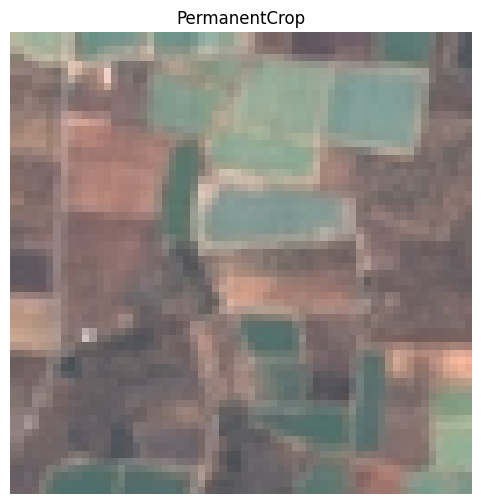

Sample pixel values (0 to 1 range): [180. 183. 156. 177. 186.]
Min and max pixel values: 74.0 248.0


2024-05-05 01:03:10.842952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [69]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(class_names[tf.argmax(labels[0])])
    plt.axis('off')
    plt.show()
    
    print("Sample pixel values (0 to 1 range):", images[0].numpy().flatten()[0:5])
    print("Min and max pixel values:", images[0].numpy().min(), images[0].numpy().max())


In [70]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
validation_ds = val_ds.skip(val_batches // 5)


print('Number of training batches:', tf.data.experimental.cardinality(train_ds).numpy())
print('Number of validation batches:', tf.data.experimental.cardinality(validation_ds).numpy())
print('Number of test batches:', tf.data.experimental.cardinality(test_ds).numpy())

Number of training batches: 775
Number of validation batches: 156
Number of test batches: 38


2024-05-05 01:03:10.923071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


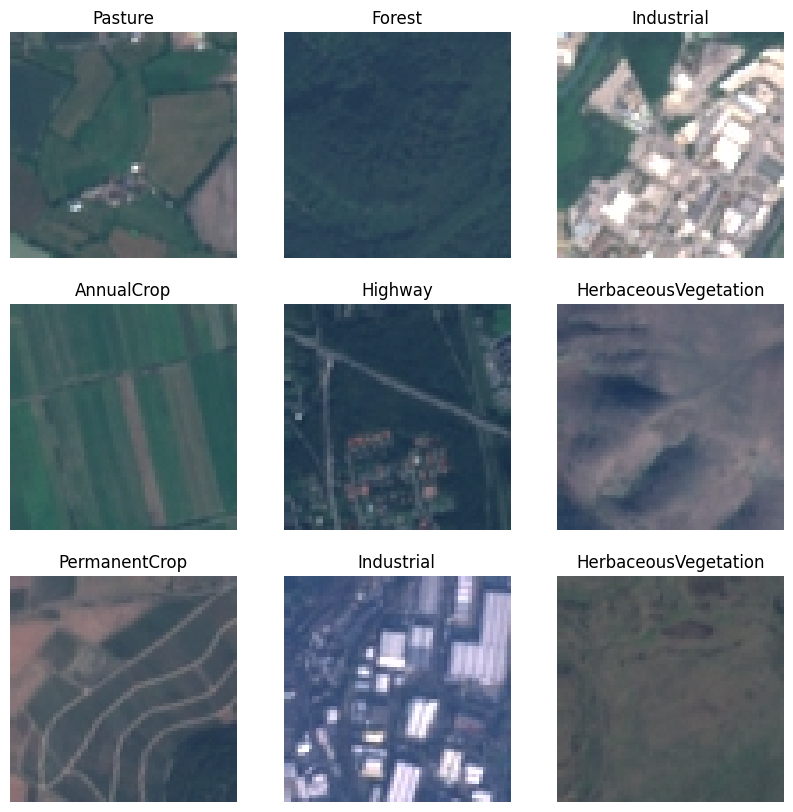

In [71]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")


In [72]:
number_of_classes = len(train_ds.class_names)

### Data Augmentation Description
To enhance the robustness of the model against variations in real-world satellite images, several data augmentation techniques were applied. These included random flips (both horizontal and vertical), random rotations (up to 20 degrees), random zoom (up to 20%), and random contrast adjustments. These techniques help simulate different capture conditions and photographic variations, aiding the model in learning more generalized features.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

def augment_data(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

2024-05-05 01:03:11.358116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


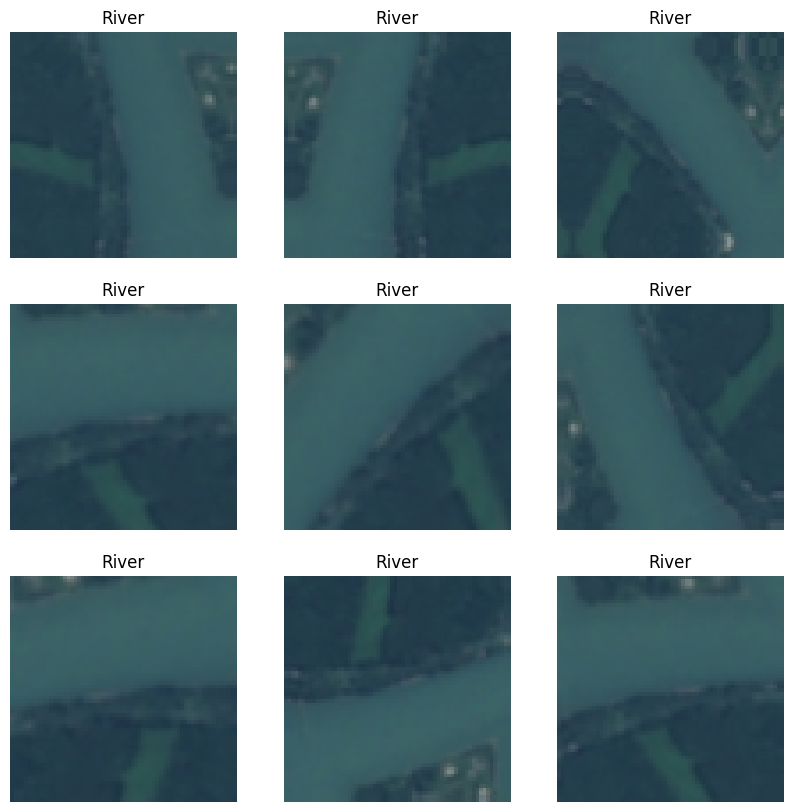

In [74]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    class_index = np.argmax(labels[0])
    class_name = class_names[class_index]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")


In [75]:
dataset_length = tf.data.experimental.cardinality(train_ds).numpy()

print("Length of the TensorFlow dataset:", dataset_length)

Length of the TensorFlow dataset: 775


## Model Training

### Initial Training and Fine Tuning
The model's initial training utilized a pre-trained EfficientNetB0 architecture with the top layers tailored for our classification needs. The base model's layers were initially frozen. Fine-tuning was later applied by unfreezing all layers and continuing training, which refined the model's ability to classify complex images more accurately.

### Comparison of Performance
Initially, the model achieved a validation accuracy of around 92%. Post fine-tuning, this accuracy improved to approximately 94%. This indicates the effectiveness of fine-tuning in enhancing the model's capability to distinguish subtle features in satellite images.


In [76]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

def create_efficientnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    base_model.trainable = False 


    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x) 
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def fine_tune_model(model, train_ds, val_ds, epochs):
    base_model = model.layers[1]
    base_model.trainable = True

    model.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_fine = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

    return history_fine

train_ds = augment_data(train_ds)

model = create_efficientnet_model((64, 64, 3), len(class_names))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]




In [77]:
initial_epochs = 10
history = model.fit(train_ds, validation_data=validation_ds, epochs=initial_epochs, callbacks=callbacks)

Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.8013 - loss: 0.6025 - val_accuracy: 0.9022 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.8930 - loss: 0.3150 - val_accuracy: 0.9083 - val_loss: 0.2748 - learning_rate: 0.0010
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9116 - loss: 0.2614 - val_accuracy: 0.9187 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9210 - loss: 0.2349 - val_accuracy: 0.9179 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9255 - loss: 0.2102 - val_accuracy: 0.9239 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9359 - loss: 0.1938 - val_accuracy: 0.9261 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.9340 - l

In [78]:
epochs = 10
history_fine = fine_tune_model(model, train_ds, validation_ds, epochs)

Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 55s 62ms/step - accuracy: 0.9292 - loss: 0.2041 - val_accuracy: 0.9219 - val_loss: 0.2278 - learning_rate: 1.0000e-05
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9348 - loss: 0.1898 - val_accuracy: 0.9249 - val_loss: 0.2211 - learning_rate: 1.0000e-05
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9367 - loss: 0.1840 - val_accuracy: 0.9287 - val_loss: 0.2178 - learning_rate: 1.0000e-05
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9371 - loss: 0.1831 - val_accuracy: 0.9283 - val_loss: 0.2168 - learning_rate: 1.0000e-05
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9410 - loss: 0.1729 - val_accuracy: 0.9291 - val_loss: 0.2138 - learning_rate: 1.0000e-05
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9419 - loss: 0.1698 - val_accuracy: 0.9299 - val_loss: 0.2147 - learning_rate: 1.0000e-05
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/ste

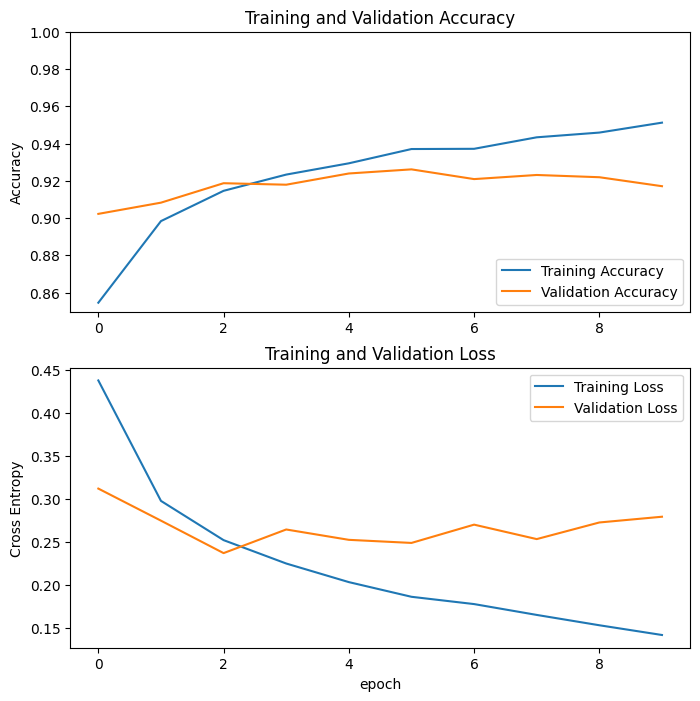

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

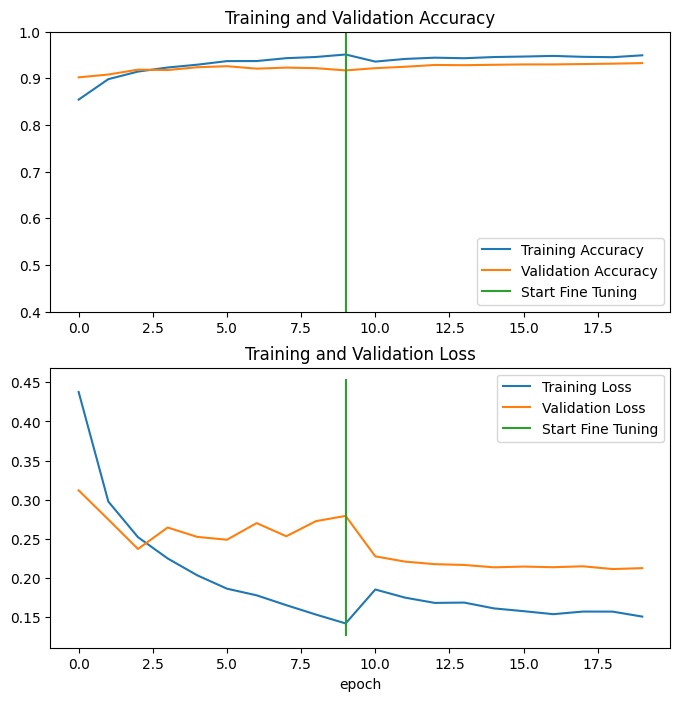

In [80]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [81]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9317 - loss: 0.2277


[0.19601286947727203, 0.9358552694320679]

In [82]:
print(model.summary())


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_16        │ (None, 64, 64, 3) │          0 │ input_layer_11[0… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 64, 64, 3) │          7 │ rescaling_16[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_17        │ (None, 64, 64, 3) │          0 │ normalization_5[… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 65, 65, 3) │          0 │ rescaling_17[0][… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 32, 32,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 32, 32,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 32, 32,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 32, 32,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 32, 32,    │        512 │ block1a_se_excit

 Total params: 6,418,883 (24.49 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 1,579,542 (6.03 MB)

None


In [83]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9380 - loss: 0.2024


[0.20488472282886505, 0.9358552694320679]

In [84]:
import numpy as np
import tensorflow as tf

y_true = []
y_pred = []

for images, labels in test_ds:

    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1) 


    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

2024-05-05 01:16:54.328388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


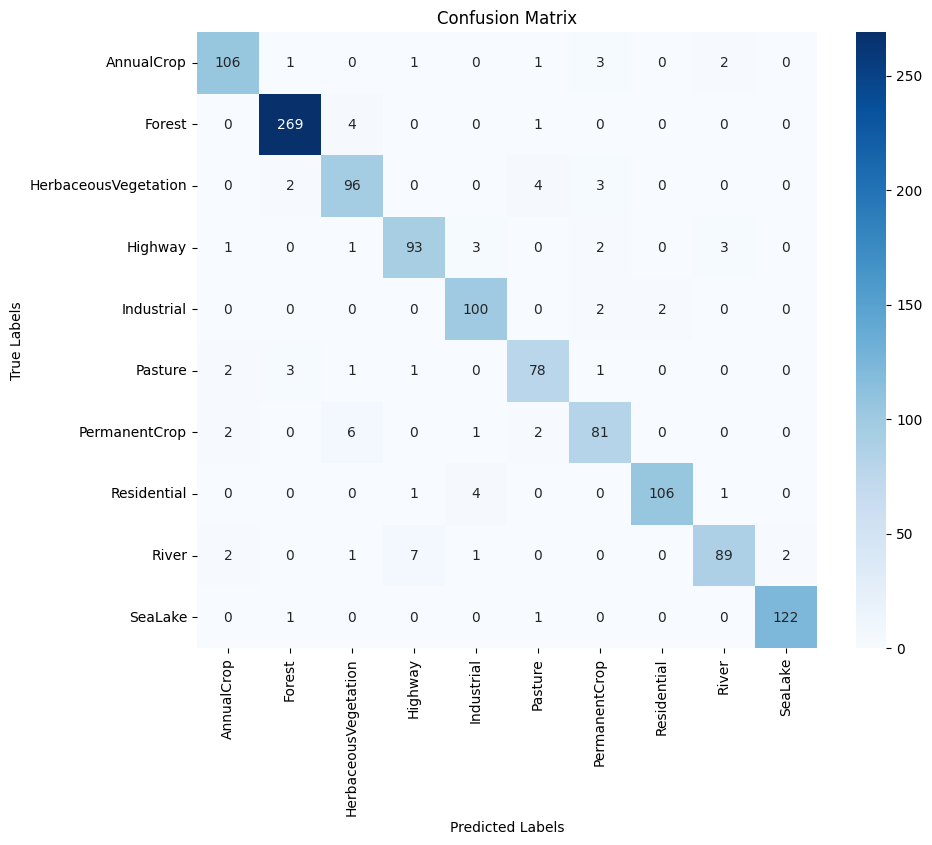

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)a

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [86]:
model.save('sentinel_classificatiion_model_generated.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


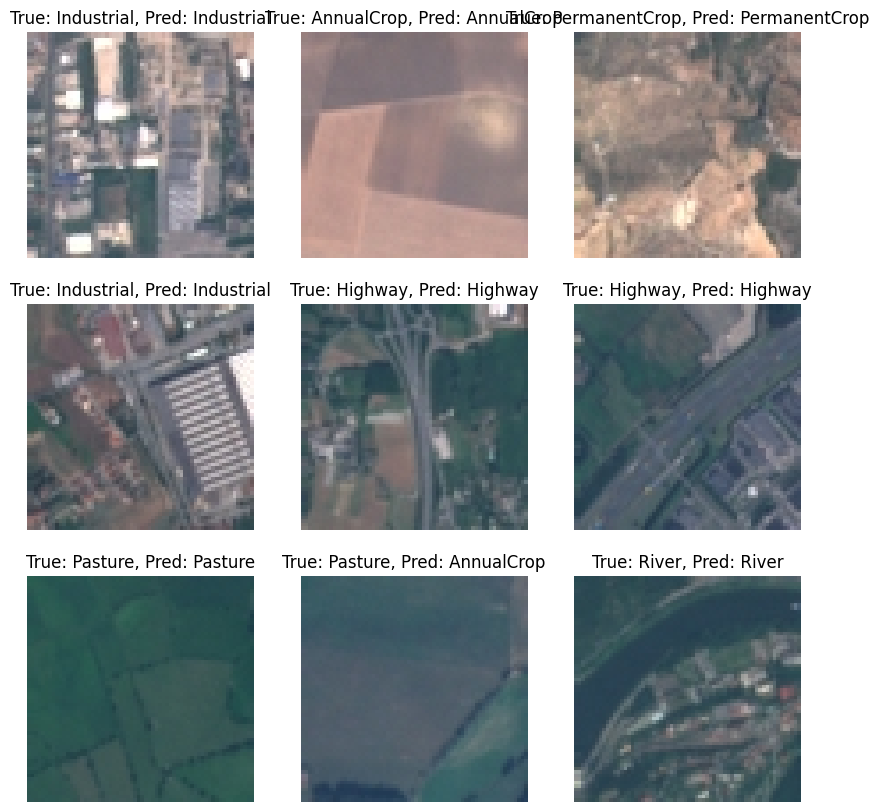

2024-05-04 23:42:16.121259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

def plot_images(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[np.argmax(labels[i])]}, Pred: {class_names[np.argmax(predictions[i])]}")
        plt.axis("off")


for images, labels in test_ds.take(1): 
    predictions = model.predict(images)
    plot_images(images, labels, predictions)
    plt.show()


## Model Application

### Deployment
The model was deployed using a Gradio web interface, which provides a user-friendly GUI for uploading images and receiving instant classifications.

### Demo
A live demo of the application can be accessed at: [https://huggingface.co/spaces/Lars2000/sentinel](https://huggingface.co/spaces/Lars2000/sentinel)

### Results of User Validation
User feedback highlighted the application's ease of use and accuracy. Positive points included quick response times and informative confidence scores for different classifications. Suggestions for improvement were focused on enhancing performance with low-contrast images and those affected by cloud cover.

## Conclusion

The project successfully demonstrated the application of convolutional neural networks in classifying satellite imagery, utilizing both transfer learning and fine-tuning approaches to achieve high accuracy. Future improvements could address the challenges identified through user feedback, potentially involving the incorporation of additional data preprocessing steps or advanced neural network architectures.
